In [5]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from timm import create_model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
from numpy import interp  # Replacing scipy interp with numpy's interp


In [6]:
# Set the directory where the lung CT scan images for COVID-19 are stored
data_dir = 'C:/Users/Hello/OneDrive/Desktop/project/covid data'

# Define a series of transformations to preprocess the images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping to augment data
    transforms.RandomRotation(10),  # Rotate images randomly by up to 10 degrees for augmentation
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images using predefined mean and standard deviation
])

# Create a dataset by loading images from the specified directory and applying the transformations
dataset = ImageFolder(data_dir, transform=transform)

# Splitting the dataset into training, validation, and testing sets:
train_size = int(0.8 * len(dataset))  # 80% of data for training
val_size = int(0.1 * len(dataset))  # 10% of data for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])  # Perform the actual split

# Create data loaders for each set (train, validation, test) to enable batch processing and shuffling:
batch_size = 32  # Number of images processed in each batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Training loader with shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Validation loader without shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Test loader without shuffling


In [7]:
# Load the pre-trained EfficientNetB1 model with custom settings
model = create_model("efficientnet_b1", pretrained=True, num_classes=len(dataset.classes))
# 'pretrained=True' loads a model pre-trained on ImageNet
# 'num_classes=len(dataset.classes)' sets the number of output classes based on the dataset

# Define the loss function and the optimizer for training:
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is commonly used for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Set up the device (GPU or CPU) for training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 'torch.device' selects 'cuda' if a GPU with CUDA is available, otherwise defaults to CPU
model.to(device)  # Move the model to the specified device (GPU or CPU) for computation efficiency
print('done')


done



Epoch 1/10 - Train Loss: 0.5882 - Train Accuracy: 92.89% - Validation Loss: 0.0766 - Validation Accuracy: 98.46%



Epoch 2/10 - Train Loss: 0.0880 - Train Accuracy: 97.36% - Validation Loss: 0.0767 - Validation Accuracy: 97.39%



Epoch 3/10 - Train Loss: 0.0685 - Train Accuracy: 97.88% - Validation Loss: 1.0112 - Validation Accuracy: 99.05%



Epoch 4/10 - Train Loss: 0.0404 - Train Accuracy: 98.61% - Validation Loss: 0.0227 - Validation Accuracy: 99.53%



Epoch 5/10 - Train Loss: 0.0522 - Train Accuracy: 98.61% - Validation Loss: 0.0125 - Validation Accuracy: 99.53%



Epoch 6/10 - Train Loss: 0.0428 - Train Accuracy: 98.79% - Validation Loss: 0.6354 - Validation Accuracy: 81.38%



Epoch 7/10 - Train Loss: 0.0280 - Train Accuracy: 99.02% - Validation Loss: 0.0072 - Validation Accuracy: 99.64%



Epoch 8/10 - Train Loss: 0.0207 - Train Accuracy: 99.45% - Validation Loss: 0.0176 - Validation Accuracy: 99.64%



Epoch 9/10 - Train Loss: 0.0235 - Train Accuracy: 99.29% - Validation Loss: 0.0153 - Validation Accuracy: 99.41%



Epoch 10/10 - Train Loss: 0.0329 - Train Accuracy: 98.84% - Validation Loss: 0.1720 - Validation Accuracy: 93.48%
   Epoch  Training Loss  Training Accuracy  Validation Loss  \
0      1       0.588241          92.889942         0.076584   
1      2       0.087972          97.363354         0.076695   
2      3       0.068467          97.881795         1.011249   
3      4       0.040394          98.607614         0.022703   
4      5       0.052222          98.607614         0.012480   
5      6       0.042780          98.785365         0.635434   
6      7       0.028001          99.022367         0.007164   
7      8       0.020684          99.451933         0.017636   
8      9       0.023508          99.288994         0.015285   
9     10       0.032936          98.844616         0.171990   

   Validation Accuracy  
0            98.457888  
1            97.390273  
2            99.051008  
3            99.525504  
4            99.525504  
5            81.376038  
6            99.

Test accuracy: 93.49%


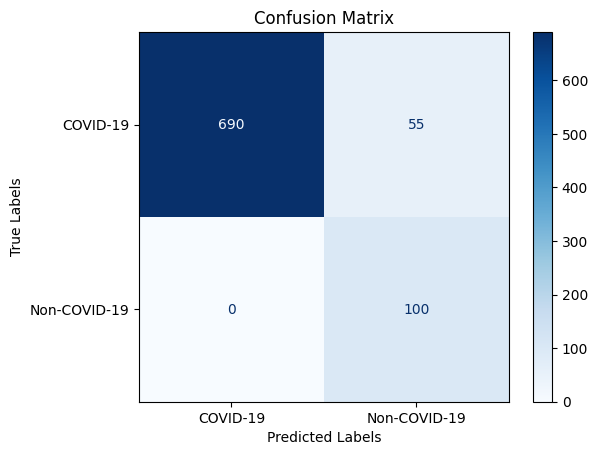

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Access 'classes' from the original dataset
num_classes = len(dataset.classes)

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=range(num_classes))

# Visualize the confusion matrix
class_names = dataset.classes
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


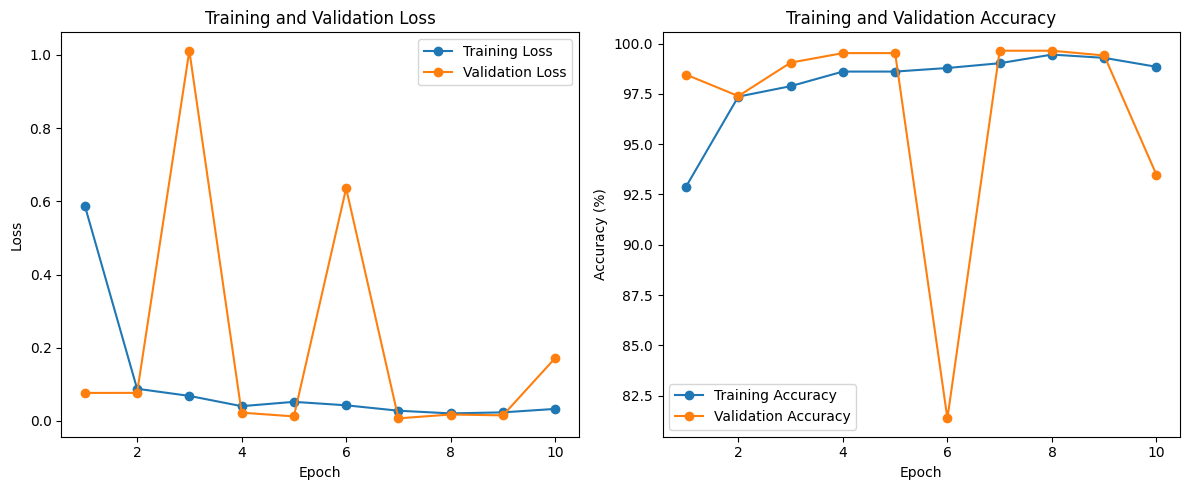

In [10]:
import matplotlib.pyplot as plt

# Extract metrics from the DataFrame
epochs = metrics_df["Epoch"]
train_loss = metrics_df["Training Loss"]
train_accuracy = metrics_df["Training Accuracy"]
val_loss = metrics_df["Validation Loss"]
val_accuracy = metrics_df["Validation Accuracy"]

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


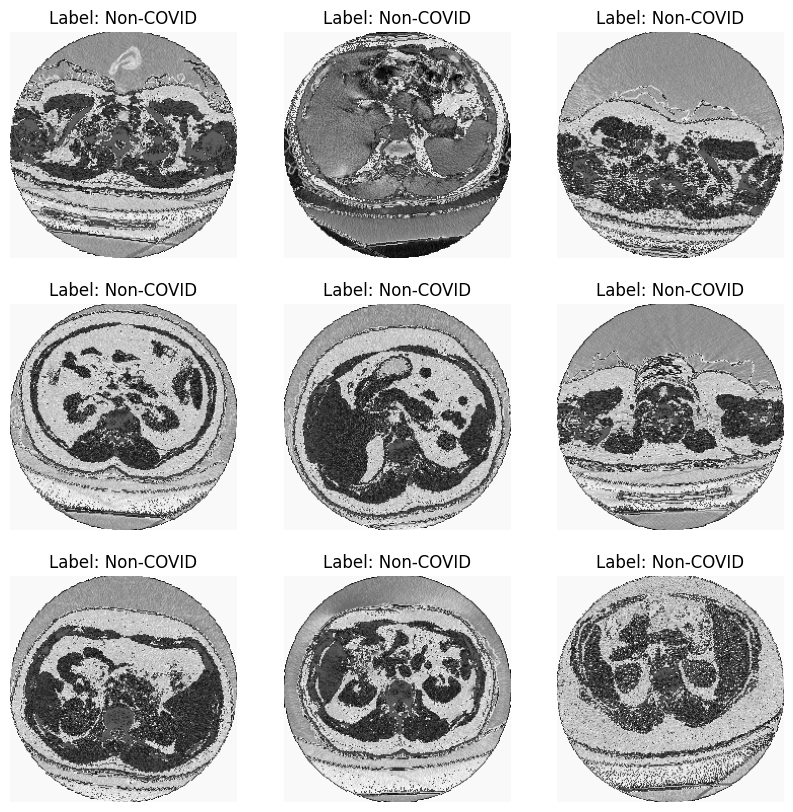

In [11]:
def visualize_dataset(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        image, label = dataset[i]
        image = transforms.ToPILImage()(image).convert("L")  # Convert to grayscale
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {'COVID' if label == 1 else 'Non-COVID'}")
        plt.axis('off')
    plt.show()

# Visualizing the first 9 grayscale images from the dataset
visualize_dataset(dataset)

In [12]:
import matplotlib.pyplot as plt

# Assuming 'model' is the name of your trained model
model.eval()

# Get predictions for the training set
all_labels_train = []
all_predictions_train = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels_train.extend(labels.cpu().numpy())
        all_predictions_train.extend(predicted.cpu().numpy())

# Convert predictions to NumPy array
all_predictions_train = np.array(all_predictions_train)




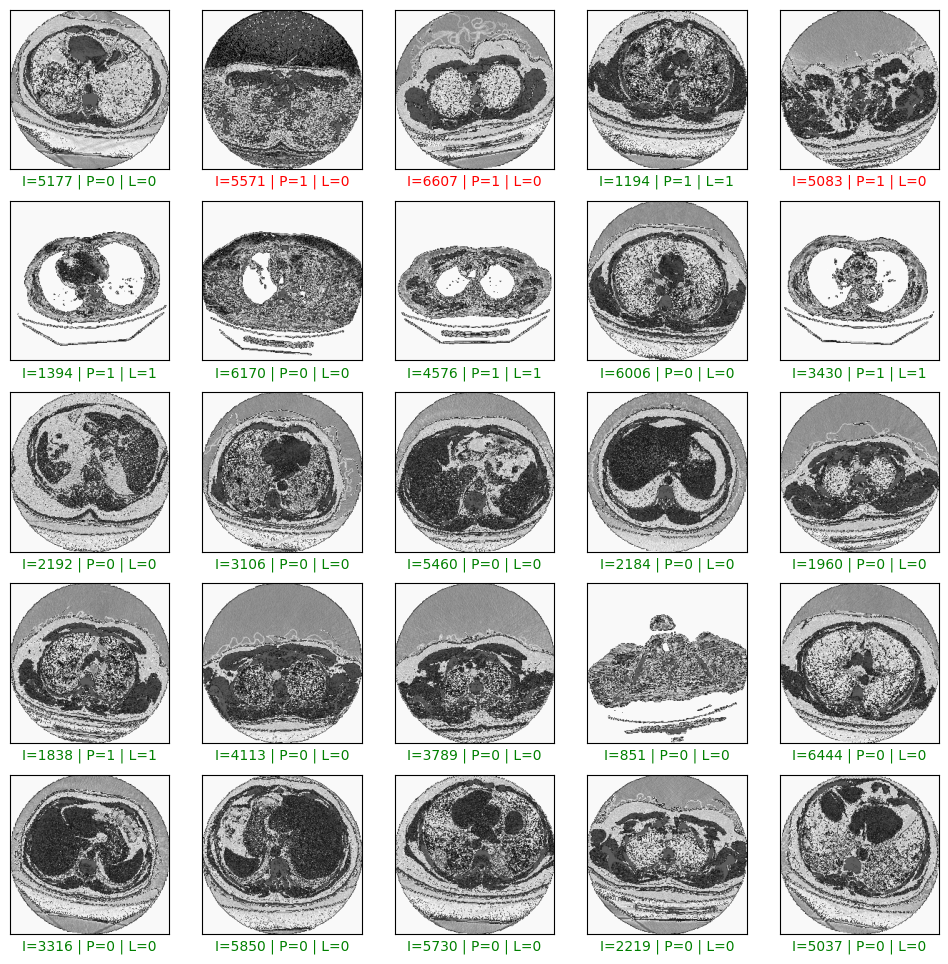

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming 'train_dataset' is a PyTorch dataset
# Make sure to replace this line with your actual dataset import and instantiation

# Randomly choose a subset of predictions for visualization
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    R = np.random.choice(len(all_predictions_train))
    pred = all_predictions_train[R]
    actual = all_labels_train[R]
    col = 'g' if pred == actual else 'r'
    
    image, _ = train_dataset[R]
    image = image.numpy().transpose(1, 2, 0)  # Assuming the image is in the format (channels, height, width)
    
    # Convert image to uint8 format before transforming to grayscale
    image_uint8 = (image * 255).astype(np.uint8)
    
    image_gray = transforms.ToPILImage()(image_uint8).convert("L")  # Convert to grayscale
    plt.imshow(image_gray, cmap='gray')
    
    plt.xlabel('I={} | P={} | L={}'.format(R, pred, actual), color=col)

plt.show()
